In [25]:
import tarfile
print("Extracting ships...")

# Open the tar.gz file
with tarfile.open('/kaggle/input/navires-2024-libre/ships24.tgz', 'r:gz') as tar:
    # Extract all files to the current directory
    tar.extractall()
    
print("Extraction done.")

Extracting ships...
Extraction done.


In [26]:
!ls /kaggle/working
!ls /kaggle/input/navires-2024-libre

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


reco_nav.csv  ships_gray  test.npy
ships24.tgz


In [27]:
# Set seed for reproducibility
SEED = 1566
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define path and image size
path = '/kaggle/working/ships_gray'
image_size = (128, 192)

# Define the classes
classes = ['coastguard_scaled', 'containership_scaled', 'corvette_scaled',
           'cruiser_scaled', 'cv_scaled', 'destroyer_scaled',
           'methanier_scaled', 'smallfish_scaled', 'submarine_scaled', 'tug_scaled']

# Create an ImageDataGenerator for (optional) augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255.0,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2,
                             height_shift_range=0.1,
                             rotation_range=0.2,
                             brightness_range=(0.8, 1.0),
                             fill_mode='nearest'
                            )

print("Datagen created.")

train_generator = datagen.flow_from_directory(
    path,
    target_size=image_size,
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    color_mode='grayscale'
)

val_generator = datagen.flow_from_directory(
    path,
    target_size=image_size,
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    color_mode='grayscale'
)

Datagen created.
Found 33768 images belonging to 10 classes.
Found 8436 images belonging to 10 classes.


In [28]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Adjust the input shape to (128, 192, 1) for grayscale images
input_tensor = Input(shape=(128, 192, 1))

# Use ResNet50 without the top layers
base_model = ResNet50(include_top=False, weights=None, input_tensor=input_tensor)

# Add global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with softmax activation for classification
output_tensor = Dense(len(classes), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_tensor)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
]



In [29]:
optimizer = Adam(learning_rate=0.001, weight_decay=1e-4)
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [30]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=100,
                    verbose=1,
                    callbacks=callbacks
                   )

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/528 ━━━━━━━━━━━━━━━━━━━━ 7:49:50 53s/step - accuracy: 0.0625 - loss: 3.3068

W0000 00:00:1717336683.090641     334 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.3942 - loss: 1.9711

W0000 00:00:1717336790.554794     334 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717336812.316235     336 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


528/528 ━━━━━━━━━━━━━━━━━━━━ 183s 246ms/step - accuracy: 0.3944 - loss: 1.9702 - val_accuracy: 0.3249 - val_loss: 2.1440 - learning_rate: 0.0010
Epoch 2/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 108s 202ms/step - accuracy: 0.6364 - loss: 1.0511 - val_accuracy: 0.6324 - val_loss: 1.1286 - learning_rate: 0.0010
Epoch 3/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 106s 199ms/step - accuracy: 0.7203 - loss: 0.8173 - val_accuracy: 0.6920 - val_loss: 0.9035 - learning_rate: 0.0010
Epoch 4/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 106s 198ms/step - accuracy: 0.7637 - loss: 0.6889 - val_accuracy: 0.6853 - val_loss: 0.9860 - learning_rate: 0.0010
Epoch 5/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 107s 201ms/step - accuracy: 0.7924 - loss: 0.5975 - val_accuracy: 0.7061 - val_loss: 0.8238 - learning_rate: 0.0010
Epoch 6/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 107s 200ms/step - accuracy: 0.8209 - loss: 0.5314 - val_accuracy: 0.7065 - val_loss: 0.9549 - learning_rate: 0.0010
Epoch 7/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 106s 199ms/step - accuracy: 0

Found 8436 images belonging to 10 classes.
Training accuracy: 0.974414
Validation accuracy: 0.919275


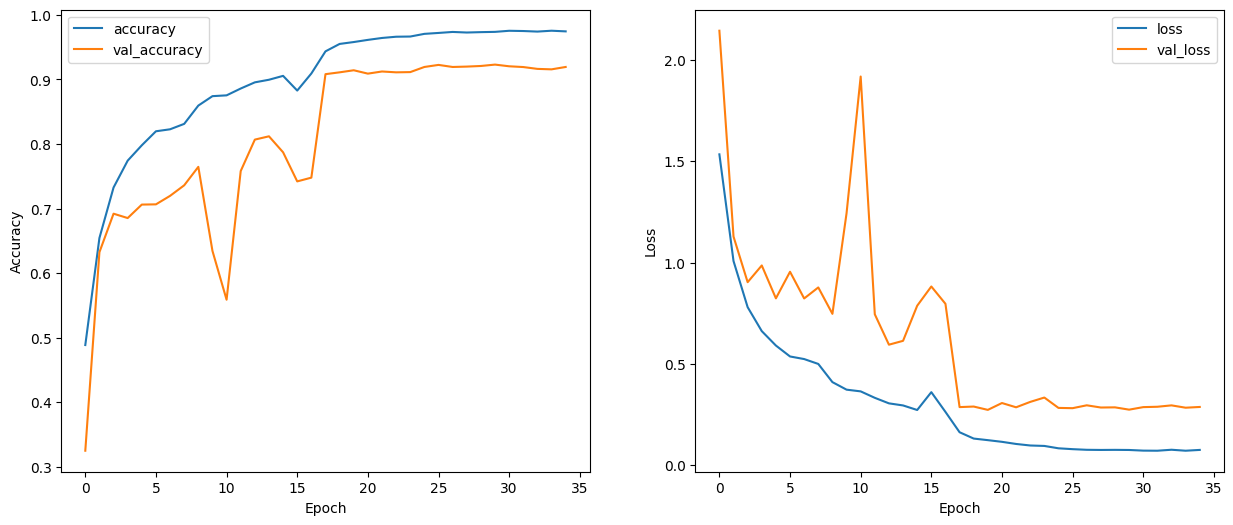

In [45]:
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(15, 6))


# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Print accuracy
print('Training accuracy: %f' % history.history['accuracy'][-1])
print('Validation accuracy: %f' % history.history['val_accuracy'][-1])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()

In [38]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  177


Found 8436 images belonging to 10 classes.
  1/132 ━━━━━━━━━━━━━━━━━━━━ 24s 185ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step


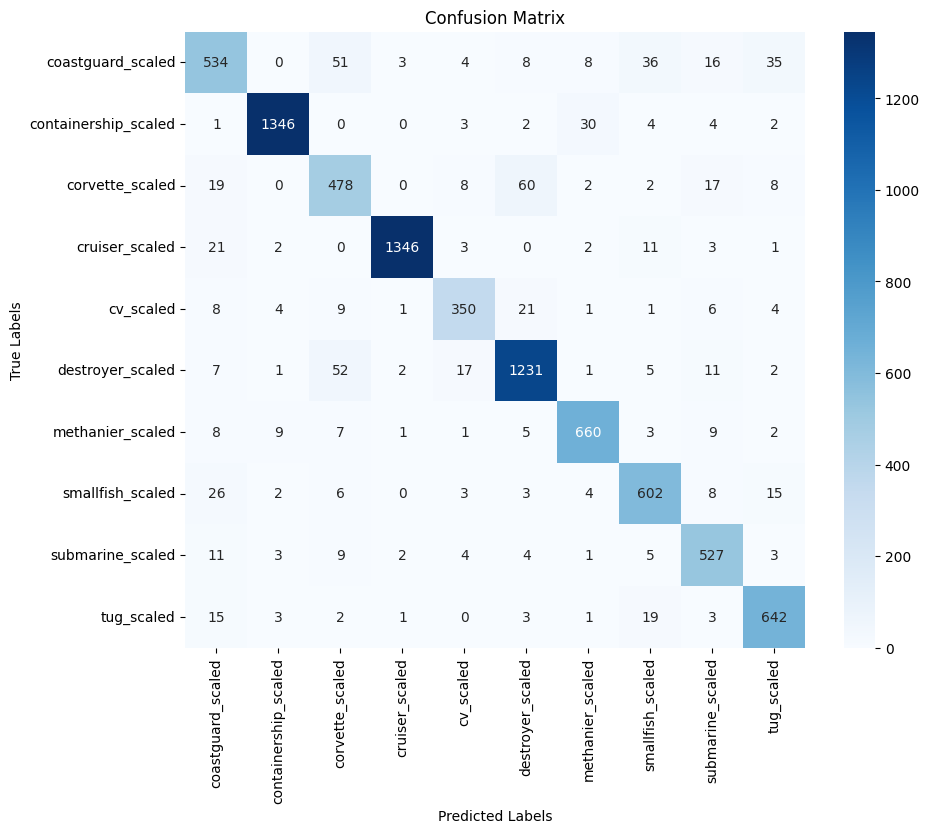

In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


val_generator = datagen.flow_from_directory(
    path,
    target_size=image_size,
    shuffle=False,
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    color_mode='grayscale'
)

# Predict using the validation generator
val_steps = val_generator.samples // val_generator.batch_size + 1
val_generator.reset()  # Ensure generator starts from the beginning
preds = model.predict(val_generator, steps=val_steps, verbose=1)

# Get true labels
val_labels = []
for i in range(val_steps):
    try:
        _, y_val = val_generator[i]
        val_labels.extend(np.argmax(y_val, axis=1))
    except:
        break  # In case of incomplete batches, break the loop

# Ensure we have the correct number of predictions
preds = np.argmax(preds[:len(val_labels)], axis=1)
val_labels = np.array(val_labels)

# Compute the confusion matrix
cm = confusion_matrix(val_labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Interprétation Globale de la Matrice de Confusion

La matrice de confusion montre les performances globales de votre modèle de classification pour différencier les types de navires. Voici les points clés à retenir :

### Précision Élevée pour Certaines Classes :
Le modèle a très bien réussi à classer certaines classes comme containership_scaled et cruiser_scaled, avec respectivement 1346 et 1346 instances correctement classées.

## Confusions Notables :
Il y a des confusions significatives entre certaines classes :
corvette_scaled est souvent confondu avec cruiser_scaled (60 instances).
coastguard_scaled est parfois confondu avec corvette_scaled (51 instances).

## Performance Globale :
La plupart des classes ont un nombre élevé de classifications correctes, ce qui indique que le modèle a bien appris à différencier ces classes.
Cependant, certaines classes comme cv_scaled et methanier_scaled montrent une dispersion plus élevée des erreurs, avec plusieurs instances mal classées.

## Axes d'Amélioration :
Les erreurs de classification entre corvette_scaled et cruiser_scaled suggèrent que ces deux classes pourraient être visuellement similaires, nécessitant peut-être une attention particulière dans la collecte de données ou l'ajustement du modèle.
Des techniques d'augmentation de données ou de régularisation peuvent aider à améliorer la performance pour les classes avec une plus grande variance d'erreur.

# Chargement des données de tests pour le `CSV`

In [47]:
X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="ID")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [48]:
!head reco_nav.csv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ID,Category
0,5
1,2
2,5
3,0
4,5
5,8
6,4
7,5
8,7


In [49]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv

# Conclusion

Nous avons testé un modèle ResNet50 pour classifier différents types de navires, mais les résultats montrent qu'il est moins performant que notre modèle fait main. La matrice de confusion révèle plusieurs confusions notables entre certaines classes, indiquant que le ResNet50 ne parvient pas à capturer les distinctions spécifiques aussi efficacement que notre propre modèle. Des améliorations sont nécessaires pour atteindre une performance comparable.